# PROJECT: Course Optimization for Data Science
## Optimization strategies for Support Vector Machines (SVM)

Authors: Alexandre Gramfort, Stéphane Gaiffas

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- derive the duals for SVMs with and without intercept
- implement an SVM using a blackbox convex toolbox (cvxopt in Python)
- implement your own solvers for the without intercept case: Proximal gradient, Coordinate Descent, Newton, Quasi-Newton
- Present a clear benchmark of the different strategies on small and medium scale datasets


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 3rd of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [6]:
# Change here using YOUR first and last names
fn1 = "leo"
ln1 = "treguer"
fn2 = "mehdi"
ln2 = "miah"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_treguer_leo_and_miah_mehdi.ipynb


Some imports

In [7]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Important:

For Part 0 to Part 2 of the project you will need a working install of `cvxopt`.
You may struggle a bit to set it up.
The simplest way of getting it is by typing 

`pip install cvxopt`

if you have `pip` installed on your laptop.
If you **struggle too much please
contact us**.

## Part 0: SVM Classification with linear kernel

Let us consider the problem of binary classification from $n$ observations
$x_i \in \mathbb{R}^{d}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{d}\mapsto y\in\{-1,+1\}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^d \times \{-1,+1\}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

Margin and linear separating hyperplane:

<img src="separateur.png">

In the linear case, one looks for an affine function of $x$ of the form 
$f(x) = \mathrm{sign}(w^{\top} x)$ or $f(x)=\mathrm{sign}(w^{\top}x + b)$
with $w \in \mathbb{R}^d$ and $b \in \mathbb{R}$. The first case is referred
to as the **without intercept** case. Indeed the coefficient $b$ is known
as the intercept or bias term.

We will start by considering the case with intercept.

To learn $f$, we use the $n$ annotated samples and one looks for a hyperplane $P(w,b)$
such that the smallest distance to positive and negative samples
is the largest. This can be written as:
$$
 \max_{w,b} \min_{i=1:n} d(x_{i},P(w,b)) \quad
 \text{where}\quad d(x_{i},P(w,b)) = \frac{|w^{\top}x_{i}+b|}{\sqrt{w^{\top}w}} \enspace,
$$
since the signed distance from a sample $x_{i}$ to the hyperplane $P(w,b)$ is given by
$$
 \delta(x_{i},w,b) = \frac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}}.
$$
The principle described above is the maximisation of the *margin*.

One can notice that if the minimum of a set of values is larger than $m$ than all values of the set are larger than $m$. This leads to the following problem formulation:
$$
 \left\{
 \begin{array}{cll}
 \max_{(w,b)} \quad m \\
 \text{s.t.} \;\; &\forall i &\dfrac{|w^{\top}x_{i}+b|}{\sqrt{w^{\top}w}}\geq m
 \end{array}
 \right. \enspace .
$$

The hyperplane separates the space in 2 half spaces, depending if $\delta(x_{i},w,b)$ is positive or negative.

Assuming all samples are linearly separable, convince yourself that the problem can be written as:
$$
(\mathcal{P}):  \left\{
 \begin{array}{cll}
 &\min_{(w,b)} \frac{1}{2}w^{\top}w
 \\
  &y_{i}(w^{\top}x_{i}+b)\geq 1, \quad \forall i\in \{1,\cdots,n\}
 \end{array}
 \right.
$$

### Questions

- Q1: Justify that the problem $(\mathcal{P})$ is convex.

Let's remind the definition of a convex problem : the optimization problem $\displaystyle \min_{x \in \mathcal{X}}(f(x))$ is called a convex optimization problem if $\mathcal{X}$ is a convex set and $f$ is a convex function.

*Convexity of the function* <br>
The function $w \mapsto \dfrac{1}{2} w^{\top}w = \dfrac{1}{2} \displaystyle \sum_{j=1}^d w_j^2$ is clearly a convex function.

*Convexity of the set* <br>
The set is $\mathcal{X} = \{(w,b) \in \mathbb{R}^d \times \mathbb{R} \text{ such that } \forall i \in [\![1,n]\!], y_i(w^{\top}x_i+b) \geq 1\}$. <br>
Let $(w_1, b_1)$ and $(w_2, b_2)$ two elements of $\mathcal{X}$, and $\rho \in [0,1]$. <br>
We get for $w_3 = \rho w_1 + (1-\rho) w_2$ and $b_3 = \rho b_1 + (1-\rho) b_2, \forall i \in [\![1,n]\!]$ : <br>
$$
\begin{array}{rcl}
y_i(w_3^{\top}x_i+b_3) & = & y_i([\rho w_1 + (1-\rho) w_2]^{\top}x_i+\rho b_1 + (1-\rho) b_2) \\
& = & y_i(\rho w_1^{\top}x_i + (1-\rho) w_2^{\top}x_i + \rho b_1 + (1-\rho) b_2) \\
& = & \rho \underbrace{y_i(w_1^{\top}x_i + b_1)}_{\geq 1} + (1-\rho) \underbrace{y_i(w_2^{\top}x_i + b_2)}_{\geq 1} \\
& \geq & \rho + (1-\rho) \\
& \geq & 1
\end{array}
$$

Finally, $(w_3, b_3) \in \mathcal{X}$ : the set $\mathcal{X}$ is convex.

One can conclude that the problem $(\mathcal{P})$ is convex.


- Q2: By looking at the saddle points of the Lagrangian $\mathcal{L}(w, b, \mu)$, $\mu \in \mathbb{R}_+^n$, show that the dual problem $(\mathcal{D})$ can be written as:
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}
$$

and $u = (1, \dots, 1) \in \mathbb{R}^n$.

We will **assume here qualification of the contraints**.

Remark: The problem $(\mathcal{D})$ is a *quadratic program* (QP) for which their exist off-the-shelf techniques. See below.

Let's remind some elements of optimization under constraints : <br>
*** Primal problem : *** we consider the problem $ \displaystyle \inf_{x, \forall i, g_i(x) \leq 0} f(x)$ where $g_i$ are constraints ; <br>
*** Lagrangien : *** the Lagrangian $\mathcal{L}$ is given by $\mathcal{L}(x, \mu) = f(x) + \sum \mu_i g_i(x)$, where $\forall i, \mu_i \geq 0$; <br>
*** Dual function : *** the dual function is $ \displaystyle F(\mu) = \inf_x \mathcal{L}(x, \mu)$, and is concave ; <br>
*** Dual problem : *** the dual problem is given by $\displaystyle \sup_{\mu, \forall i \mu_i \geq 0} F(\mu)$ ; <br>
*** Slater's condition : *** $\exists x_0, \forall i (g_i(x_0) <0) \text{ or } (g_i(x_0)=0 \text{ and } g_i \text{ are linear})$ ; <br>
*** Saddle points : *** Let a primal problem $(\mathcal{P})$ with a Lagrangian function $\mathcal{L}$. If $(x^*, \mu^*)$ is a saddle point of $\mathcal{L}$ ie $\forall (x,\mu), \mathcal{L}(x^*, \mu) \leq \mathcal{L}(x,\mu) \leq \mathcal{L}(x, \mu^*)$. Then, $x^*$ is a solution of $(\mathcal{P})$ and $\mu$ is a solution of $(\mathcal{D})$ ; <br>
*** Existence of saddle points : *** If $f$ is convex, $\forall i, g_i$ are convex and Slater's condition is satisfied, then if $x^*$ is a solution of $(\mathcal{P})$, it exists $\mu^*$ such that $(x^*, \mu^*)$ is a saddle point of the Lagrangien ; <br>
*** Karush-Kuhn-Tucker's theorem : *** Let $f$, $\forall i, g_i$ convex and differentiable such that Slater's condition is satisfied. $x^*$ is a solution of $(\mathcal{P})$ if and only if, it exists $\mu^* (\in \mathbb{R_+}^n)$ such that : 
- $\bigtriangledown_x \mathcal{L}(x^*, \mu^*) \triangleq \bigtriangledown_x f(x^*) + \sum \mu_i^* \bigtriangledown_x g_i(x^*) = 0$
- $\bigtriangledown_{\mu_i} \mathcal{L}(x^*, \mu^*) \triangleq g_i(x^*) \leq 0, \forall i$
- $\sum \mu_i^*g_i(x^*) = 0$

For our problem with SVM, we get :
- $w \mapsto \dfrac{1}{2} w^{\top}w = \dfrac{1}{2} \parallel w \parallel^2$ is convex and differentiable ; 
- $\forall i \in [\![1,n]\!], g_i : (w,b) \mapsto 1-y_i(w^{\top}x_i + b)$ is linear ; 
- the Lagrangien function is $ \displaystyle \mathcal{L} : (w,b,\mu) \mapsto \dfrac{1}{2} \parallel w \parallel^2 + \sum_{i=1}^n \mu_i [1-y_i(w^{\top}x_i + b)]$ ; 
- the dual function is $F(\mu) = \displaystyle \inf_{(w,b)} \mathcal{L}(w,b,\mu) = \mathcal{L}(w^*, b^*, \mu)$

From KKT theorem, we get : 
- $ \displaystyle \bigtriangledown_w \mathcal{L}(w^*, b^*, \mu^*) = 0 \Longrightarrow w = \sum_{i=1}^n \mu_i y_i x_i$ ; 
- $ \displaystyle \bigtriangledown_b \mathcal{L}(w^*, b^*, \mu^*) = 0 \Longrightarrow \sum_{i=1}^n \mu_i y_i = 0$.

So, thanks to the new formula of $w$ : 
$$\begin{array}{rcl}
\mathcal{L}(w^*, b^*, \mu) & = & \displaystyle\dfrac{1}{2} \parallel \sum_{i=1}^n \mu_i y_i x_i \parallel^2 - \sum_{i,j} \mu_i \mu_j y_i y_j x_i^{\top} x_j - b \underbrace{\sum_{i=1}^n \mu_i y_i}_{=0} + \sum_{i=1}^n \mu_i \\
& = & \displaystyle - \dfrac{1}{2} \sum_{i,j} \mu_i \mu_j y_i y_j x_i^{\top} x_j + \sum_{i=1}^n \mu_i \\
F(\mu) & = & \displaystyle - \dfrac{1}{2} \mu^{\top} G G^{\top} \mu + \mu^{\top} u
\end{array}$$

with 
$
G = \begin{bmatrix}
y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}
\end{bmatrix}
$
and
$u = (1, \dots, 1) \in \mathbb{R}^n$. <br>

Finally, the dual problem is 
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \displaystyle \max_{\mu} &-\dfrac{1}{2}\mu^{\top}GG^{\top}\mu+\mu^{\top}u
 \\
 \mathrm{s.c.}& \displaystyle \sum_{i=1}^n \mu_i y_i = 0
 \\
 \mathrm{and}& \mu \geq  0
 \end{array}
 \right .
$$

which is equivalent to
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \displaystyle \min_{\mu} &\dfrac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$

- Q3: Justify that given the estimated $\mu$, the prediction function for a new sample $x$ is given by:

$$
y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b) \enspace .
$$

The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i y_i x_i$

From the KKT theorem, we get $w = \displaystyle \sum_{i=1}^n \mu_i y_i x_i$. <br>
By the way, $y=\mathrm{sign}(w^{\top}x + b)$, so we get $y = \mathrm{sign}([\displaystyle \sum_{i=1}^n \mu_i y_i x_i]^{\top}x + b)$, hence : $y = \mathrm{sign}(\displaystyle \sum_{i=1}^n \mu_i y_i x_i^{\top}x + b)$

## Part 1: Implementation of solver with intercept using cvxopt

The file svm_project_utils.py contains the code to generate some toy data and plot them

In [8]:
from svm_project_utils import plot_dataset, datasets

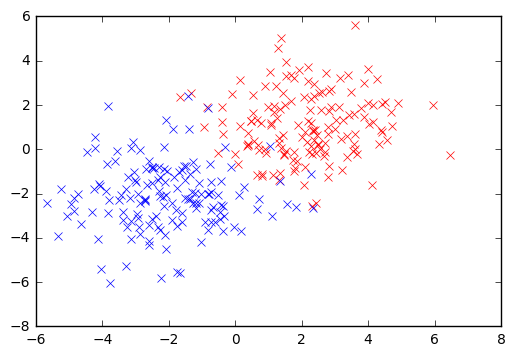

In [9]:
X, y = datasets(name='gaussian', n_points=300)
plot_dataset(X, y)

- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} H x - e^\top x
  \\
   & \textrm{s.c.}\; A^\top x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

In [10]:
import cvxopt


def qp(H, e, A, b, C=np.inf, l=1e-8, verbose=True):
    # Gram matrix
    n = H.shape[0]
    H = cvxopt.matrix(H)
    A = cvxopt.matrix(y, (1, n))
    e = cvxopt.matrix(-e)
    b = cvxopt.matrix(0.0)
    if C == np.inf:
        G = cvxopt.matrix(np.diag(np.ones(n) * -1))
        h = cvxopt.matrix(np.zeros(n))
    else:
        G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                         np.diag(np.ones(n))], axis=0))
        h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(H, e, G, h, A, b)
 
    # Lagrange multipliers
    mu = np.ravel(solution['x'])
    return mu

Definition of the linear kernel:

In [11]:
def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K

### Questions

- Q4: Modify the following cell to solve the SVM dual problem:

Number of support vectors: 3


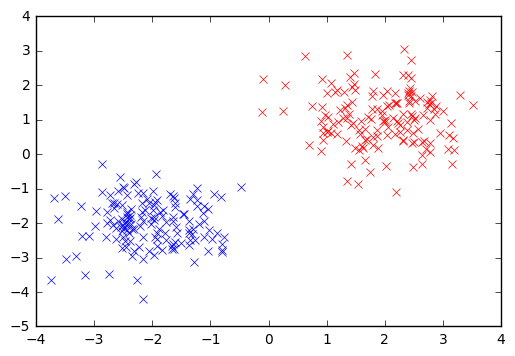

In [12]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)
plot_dataset(X, y)

# TODO
def svm_solver(K, y, C=np.inf):
    n = y.shape[0]
    
    H = np.transpose(y * np.transpose(X)).dot((y * np.transpose(X)))
    e = np.ones(n)
    A = y
    b = 0
    mu = qp(H, e, A, b, C, l=1e-8, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

K = kernel(X, X)

# Uncomment the following lines when your svm_solver is completed:
mu_support, idx_support = svm_solver(K, y)
print("Number of support vectors: %s" % idx_support.size)

- Q5: Compute w from mu and b

$w$ is equal to $\displaystyle \sum_{i=1}^{n} \mu_i y_i x_i$. As $\mu_i = 0$ for points which are not support vectors (see next question), this equation leads to $\displaystyle \sum_{\text{i in support}} \mu_i y_i x_i$

In [13]:
w = (mu_support * y[idx_support]).dot(X[idx_support, :])
print(w)

[ 1.01892609  0.74495531]


- Q6: Using complementary slackness, explain how to obtain $b$ from $\mu$.

HINT: Use the fact that for all support vectors for which $\mu_i$ is non-zero one has $y_{i}(w^{t}x_{i}+b) = 1$.

From the KKT theorem, we get also : $\displaystyle \sum_{i=1}^n \mu_i^*g_i(x^*) = 0$ which leads to : 
$$ \displaystyle \sum_{i=1}^n \underbrace{\underbrace{\mu_i}_{\geq 0 \forall i} \underbrace{[1-y_i(w^{\top}x_i + b)]}_{\leq 0 \forall i \text{ since the problem is separable}}}_{\leq 0 \forall i}= 0,$$
so we get $\forall i$, either $\mu_i = 0$ or $1-y_i(w^{\top}x_i + b) = 0$.

Finally, we get many $\mu_i = 0$ and for $i$ such that $\mu_i \neq 0$, we get $y_i(w^{\top}x_i + b) = 1$ : those points are the support vectors. We can notice that the coefficient $w$ and $b$ only depend on the support vectors. <br>

For support vectors, one obtains $y_{i}(w^{t}x_{i}+b) = 1$ hence $b = y_{i} - w^{t}x_{i}$. Then, with the new expression of $w$, we get for such a point : 
$$\begin{array}{rcl}
b & = & y_i - \displaystyle \sum_{j=1}^{n} \mu_j y_j x_j^{\top}x_i \\
& = & y_i - \displaystyle \sum_{j=1}^{n} \mu_j y_j K_{i,j} 
\end{array}$$
We get as many estimations of $b$ as number of points amongst support vectors : we take the mean of them.

In [14]:
def compute_b(K, y, mu_support, idx_support):
    y_support = y[idx_support]
    K_support = K[idx_support][:, idx_support]
    b = np.mean(y_support - (mu_support * y_support).dot(K_support))

    return b

b = compute_b(K, y, mu_support, idx_support)
print(b)

0.209544111413


- Q7: Verify that the constraints of the primal problem are satistified up to an acceptable numerical precision. You should verify that for all $i$ we have:

$$
y_{i}(w^{\top}x_{i}+b) \geq 1 - \epsilon
$$

using for example $\epsilon = 1e-5$.

In [15]:
epsilon = 10**(-5)
print(min(y * (X.dot(w) + b)))
print(min(y * (X.dot(w) + b)) >= 1-epsilon)

0.999999337783
True


We can check that for a separable problem, the constraints are satisfied.

Check your code by running the following cell:

Number of support vectors: 3


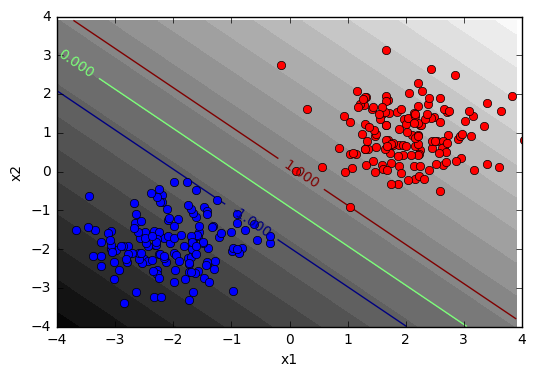

In [16]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)

K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
print("Number of support vectors: %s" % idx_support.size)

b = compute_b(K, y, mu_support, idx_support)

def plot_classif(X, y, mu_support, idx_support, b, kernel=kernel):
    # Calcul de la fonction de décision sur une grille
    X1, X2 = np.mgrid[-4:4:0.1, -4:4:0.1]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Calcul des produits scalaires
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Calcul de la fonction de décision
    decision = G.dot(mu_support * y[idx_support]) + b

    # Calcul du label prédit
    y_pred = np.sign(decision)

    # Affichage des lignes de niveau de la fonction de decision
    plt.contourf(X1, X2, np.reshape(decision, (na, nb)), 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, np.reshape(decision, (na,nb)), [-1, 0, 1], color='g', linewidth=2)
    plt.clabel(cs, inline=1)
    plt.plot(X[y == 1,0], X[y == 1, 1], 'or', linewidth=2)
    plt.plot(X[y == -1,0], X[y == -1, 1], 'ob', linewidth=2)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

plot_classif(X, y, mu_support, idx_support, b)

We will now change the value of $\sigma$ such that the problem is not linearily separable anymore.

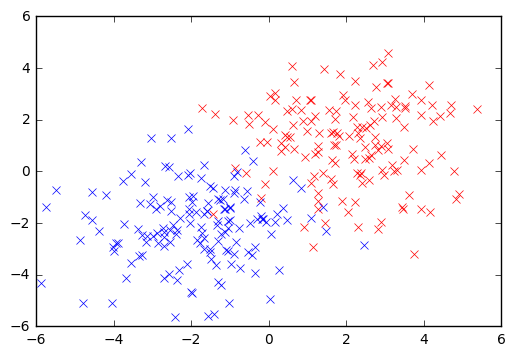

In [17]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.5)
plot_dataset(X, y)

In [18]:
K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)
w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)

Terminated (singular KKT matrix).


- Q8: Check that contraints of the problem are now violated.

In [19]:
epsilon = 10**(-5)
print(min(y * (X.dot(w) + b)) >= 1-epsilon)
print(min(y * (X.dot(w) + b)))

False
-6.58263773547e-05


We notice that the constraints are no longer satisfied : we need to introduce slack variables.

## Part 1: Non separable case with cvxopt

In practice it is very likely that the classes are not linearly separable.

A very natural idea is to relax the constraints $y_{i}(w^\top x_i + c) \geq 1$.
To do this, so called soft-margin SVM have been introduced using
so called slack variables: $\xi_{i}\geq 0$. The problem becomes:

$$
 y_{i}(w^\top x_i + b) \geq 1 - \xi_i, \; \xi_i \geq 0 \enspace .
$$

Note that if $\xi_i > 1$, the sample $x_{i}$ will be misclassified. To prevent
this case to be too frequent, an idea is to minimize the sum of the $\xi_{i}$.
This leads to the following problem:

$$
(P_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,b,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}+b) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

The constant $C$ controls the regularisation.

### Questions

- Q9: Justify that $(P_{s})$ is a convex problem

*Convexity of the function* <br>
Let's consider the function $\displaystyle (w,\xi) \mapsto \dfrac{1}{2}w^{\top}w + C \sum_i \xi_i = \dfrac{1}{2} \sum_{j=1}^d w_j^2 + C \sum_{i=1}^n \xi_i$. As a sommation of convex an linear functions, this function is convex. <br>

*Convexity of the set* <br>
Let's consider the set $\mathcal{X} = \{ (w,b,\xi) \text{ such that } \forall i \,,  y_i(w^{\top}x_i+b) \geq 1 - \xi_i \text{ and } \xi_i \geq 0\}$. Let $(w_1, b_1, \xi_1), (w_2, b_2, \xi_2) \in \mathcal{X}$ and $\rho \in [0,1]$. We put : <br>
$$
\begin{bmatrix}
w_3 \\
b_3 \\
\xi_3 \\
\end{bmatrix} = 
\rho
\begin{bmatrix}
w_1 \\
b_1 \\
\xi_1 \\
\end{bmatrix}
+ (1-\rho)
\begin{bmatrix}
w_2 \\
b_2 \\
\xi_2 \\
\end{bmatrix}
$$

Firstly, we get $\forall i \in [\![1,n]\!]$:
$$
\begin{array}{rcl}
y_i(w_3^{\top}x_i+b_3) & = & y_i([\rho w_1 + (1-\rho) w_2]^{\top}x_i + \rho b_1 + (1-\rho) b_2) \\
& = & \rho \underbrace{y_i(w_1^{\top}x_i + b_1)}_{\geq 1-\xi_{1_i}} + (1-\rho) \underbrace{y_i (w_2^{\top}x_i + b_2)}_{\geq 1-\xi_{2_i}} \\
& \geq & \rho(1-\xi_{1_i}) + (1-\rho)(1-\xi_{2_i}) \\
& \geq & 1 - \underbrace{[\rho \xi_{1_i} + (1-\rho)\xi_{2_i}]}_{\xi_{3_i}} \\
& \geq & 1 - \xi_{3_i}
\end{array}
$$

Secondly, we get $\forall i \in [\![1,n]\!]$ :
$$
\begin{array}{rcl}
\xi_{3_i} & = &\rho \underbrace{\xi_{1_i}}_{\geq 0} + (1-\rho)\underbrace{\xi_{2_i}}_{\geq 0} \\
& \geq & 0
\end{array}
$$

Finally, $(w_3, b_3, \xi_3) \in \mathcal{X}$ : one can conclude that this set is convex.

*Conclusion* <br>
That is why the problem is convex.

- Show that a dual problem of $(P_{s})$ reads:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{and}& 0 \leq \mu \leq C
\end{array}
\right .
$$

For our problem with soft-margin SVM , we get :
- $(w, \xi) \mapsto \dfrac{1}{2} w^{\top}w + C \displaystyle \sum_i \xi_i = \dfrac{1}{2} \parallel w \parallel^2 + C \sum_i \xi_i$ is convex and differentiable ; 
- $\forall i \in [\![1,n]\!], g_{i} : (w,b,\xi) \mapsto 1-\xi_i-y_i(w^{\top}x_i + b)$ is linear ; 
- $\forall i \in [\![1,n]\!], h_{i} : (\xi) \mapsto -\xi_i$ is linear ; 
- the Lagrangien function is $ \displaystyle \mathcal{L} : (w,b,\alpha \in \mathbb{R}_+^n, \beta \in \mathbb{R}_+^n) \mapsto \dfrac{1}{2} \parallel w \parallel^2 + C \sum_{i=1}^n \xi_i + \sum_{i=1}^n \alpha_{i} [1-\xi_i-y_i(w^{\top}x_i + b)] - \sum_{i=1}^n \beta_{i}\xi_i $ ; 
- the dual function is $F(\alpha, \beta) = \displaystyle \inf_{(w,b)} \mathcal{L}(w,b,\alpha, \beta) = \mathcal{L}(w^*, b^*, \alpha, \beta)$

From KKT theorem, we get : 
- $ \displaystyle \bigtriangledown_w \mathcal{L}(w^*, b^*, \alpha^*, \beta^*) = 0 \Longrightarrow w = \sum_{i=1}^n \alpha_{i} y_i x_i$ ; 
- $ \displaystyle \bigtriangledown_b \mathcal{L}(w^*, b^*, \alpha^*, \beta^*) = 0 \Longrightarrow \sum_{i=1}^n \alpha_{i} y_i = 0$ ; 
- $ \displaystyle \bigtriangledown_{\xi} \mathcal{L}(w^*, b^*, \alpha^*, \beta^*) = 0 \Longrightarrow C = \alpha_{i} + \beta_{i}, \forall i$.

So, thanks to the new formula of $w$ and $\beta_i$: 
$$\begin{array}{rcl}
\mathcal{L}(w^*, b^*, \alpha, \beta) & = & \displaystyle\dfrac{1}{2} \parallel \sum_{i=1}^n \alpha_{i} y_i x_i \parallel^2 + C \sum_{i=1}^n \xi_i + \sum_{i=1}^n \alpha_i - \sum_{i=1}^n \alpha_i \xi_i -\sum_{i,j} \alpha_{i} \alpha_{j} y_i y_j x_i^{\top} x_j - b \underbrace{\sum_{i=1}^n \alpha_i y_i}_{=0} - \sum_{i=1}^n (C-\alpha_i)\xi_i\\
& = & \displaystyle\dfrac{1}{2} \parallel \sum_{i=1}^n \alpha_{i} y_i x_i \parallel^2 + \sum_{i=1}^n \alpha_i -\sum_{i,j} \alpha_{i} \alpha_{j} y_i y_j x_i^{\top} x_j \\
& = & \displaystyle - \dfrac{1}{2} \sum_{i,j} \alpha_i \alpha_j y_i y_j x_i^{\top} x_j + \sum_{i=1}^n \alpha_i \\
F(\alpha, \beta) & = & \displaystyle - \dfrac{1}{2} \alpha^{\top} G G^{\top} \alpha + \alpha^{\top} u
\end{array}$$

with 
$
G = \begin{bmatrix}
y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}
\end{bmatrix}
$
and
$u = (1, \dots, 1) \in \mathbb{R}^n$. <br>

Finally, the dual problem is 
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \displaystyle \max_{\alpha} &-\dfrac{1}{2}\alpha^{\top}GG^{\top}\alpha+\alpha^{\top}u
 \\
 \mathrm{s.c.}& \displaystyle \sum_{i=1}^n \alpha_i y_i = 0
 \\
 \mathrm{and}& \alpha_i = C - \beta_i \text{ with } \alpha_i \geq 0 \text{ and } \beta_i \geq 0 \forall i
 \end{array}
 \right .
$$

which is equivalent to
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \displaystyle \min_{\mu} &\dfrac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& 0 \leq \mu_i \leq C , \forall i
 \end{array}
 \right .
$$

- Q10: Modify your code from Q4 to handle the non-separable case.

Number of support vectors: 102


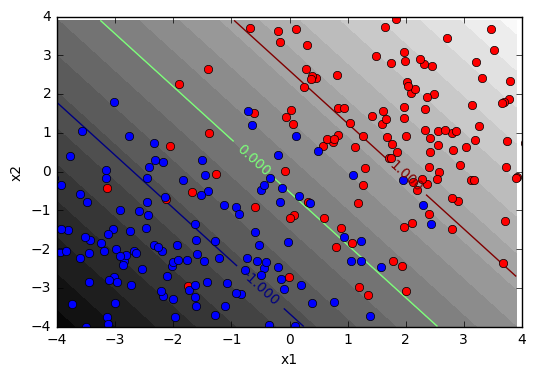

In [20]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.7)

K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y, C = 0.01) #We used C
b = compute_b(K, y, mu_support, idx_support)
print("Number of support vectors: %s" % idx_support.size)
plot_classif(X, y, mu_support, idx_support, b)

- Q11: What is the influence of C on the number of support vectors? Justify this from an optimization stand point.

Number of support vectors: 204


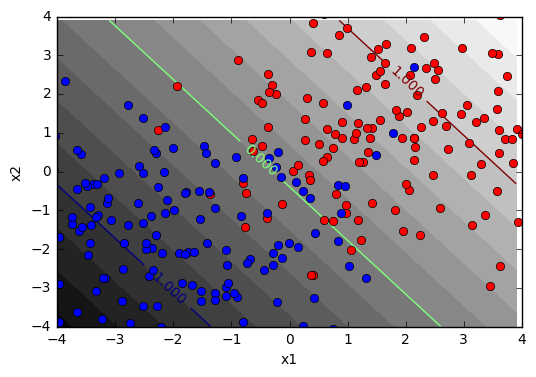

In [21]:
# When the coefficient C is small (10^(-3))
X, y = datasets(name='gaussian', n_points=300, sigma=1.7)
K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y, C = 0.001)
b = compute_b(K, y, mu_support, idx_support)
print("Number of support vectors: %s" % idx_support.size)
plot_classif(X, y, mu_support, idx_support, b)

Number of support vectors: 63


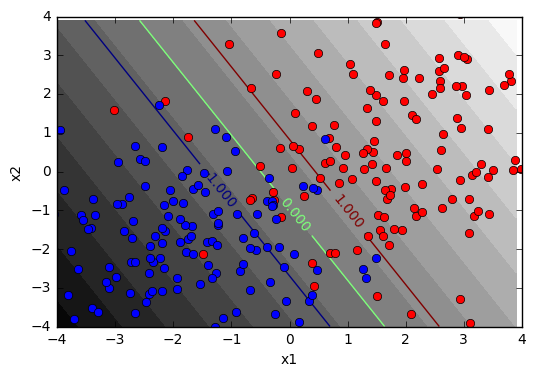

In [22]:
# When the coefficient C is big (10^(+3))

X, y = datasets(name='gaussian', n_points=300, sigma=1.7)
K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y, C = 1000)
b = compute_b(K, y, mu_support, idx_support)
print("Number of support vectors: %s" % idx_support.size)
plot_classif(X, y, mu_support, idx_support, b)

One can notice that when the coefficient $C$ is small, the margin is big even if there are too many mis-classified points. On the contrary, when the coefficient is big, the margin is smaller. Indeed, the coefficient $C$ indicates how much we want to penalize misclassifying example. <br>
As for the number of support vectors, the smaller $C$ is, the stricter the condition $0\leq \mu_i \leq C$ is. So we will get many support vectors for very small $C$. And, when the coefficient is great, the condition does not influence the problem. <br>
We can determine the number of support vectors for some values of $C$ : 

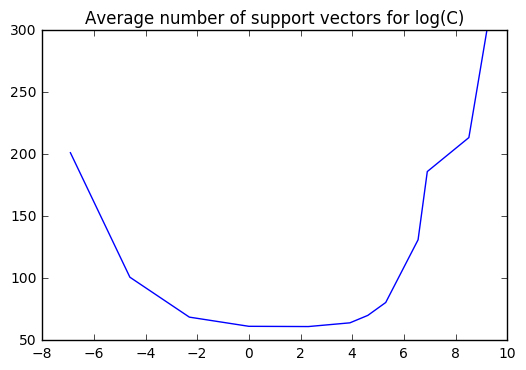

In [23]:
K = kernel(X, X)

#The values of C that will be tested
vect_C = np.array([0.001, 0.01, 0.1, 1, 10, 50, 100, 200, 700, 1000, 5000, 10000])
nb_C = vect_C.size

#The number of iterations to reduce the variance
N_iter = 5

#The matrix containing the number of support vectors for each trial
mat_number = np.zeros([N_iter, nb_C])

for n in range(N_iter) : 
    X, y = datasets(name='gaussian', n_points=300, sigma=1.7)
    for ind_C in range(nb_C) :
        mu_support, idx_support = svm_solver(K, y, C=vect_C[ind_C])
        mat_number[n, ind_C] = idx_support.size

plt.title("Average number of support vectors for log(C)")        
plt.plot(np.log(vect_C), np.mean(mat_number, axis = 0))    

## Part 2: non-linear case with kernels

Another scenario is when the boundary between classes is not linear.

To cope with this the idea is to use kernels.

- Q12: Denoting by $K(x_i, x_j)$ the dot product between samples show that dual problem and the decision function $f(x)$ can be reformulated just using calls to $K$

We take the separable problem : as previously seen, the dual problem is 
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \displaystyle \min_{\mu} &\dfrac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$


which is equivalent to 
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \displaystyle \min_{\mu} & - \dfrac{1}{2} \displaystyle \sum_{i,j} \mu_i \mu_j y_i y_j x_i^{\top} x_j + \sum_{i=1}^n \mu_i
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$

and to 
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \displaystyle \min_{\mu} & - \dfrac{1}{2} \displaystyle \sum_{i,j} \mu_i \mu_j y_i y_j K(x_i,x_j) + \sum_{i=1}^n \mu_i
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$

From then on, the output $y$ is equal to : 
$$\begin{array}{rcl}
y & = & \mathrm{sign}(\displaystyle \sum_{i=1}^n \mu_i y_i x_i^{\top}x + b) \\
f(x) & = & \mathrm{sign}(\displaystyle \sum_{i=1}^n \mu_i y_i K(x_i, x) + b)
\end{array}$$

We will use the clowns dataset to evaluate this:

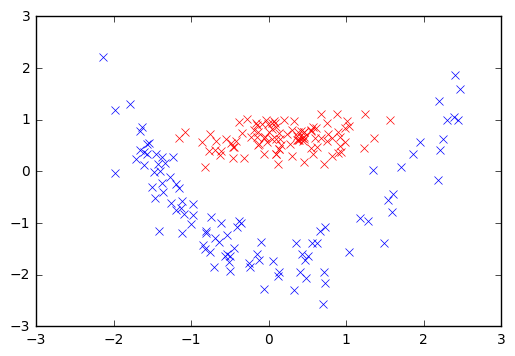

In [24]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

plot_dataset(X, y)

- Q13: Update your kernel function so it computes the Gaussian kernel:

$$
    K(x_i, x_j) = \exp(-\gamma \| x_i - x_j \|)
$$

where $\gamma > 0$ is the kernel bandwidth.

In [25]:
from scipy import linalg

def rbf_kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    gamma = 3.
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.exp(-gamma * linalg.norm(X1[i]-X2[j]))
    return K

Using the change above the follwing code should allow you to nicely separate the red from the blue dots

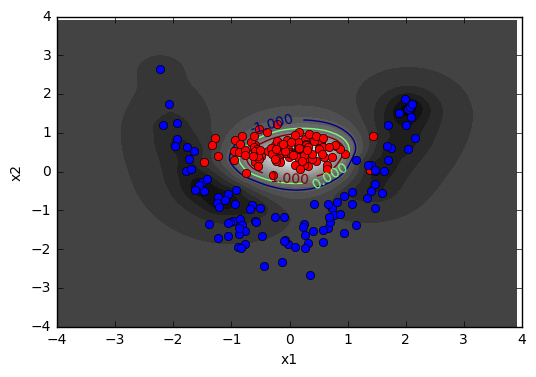

In [26]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

K = rbf_kernel(X, X)
mu_support, idx_support = svm_solver(K, y, C = 0.5)
b = compute_b(K, y, mu_support, idx_support)

plot_classif(X, y, mu_support, idx_support, b, kernel=rbf_kernel)

## Part 3: Linear SVM without intercept

The problem of the formuation of SVMs with the intercept term $b$ is that
it leads to an annoying constraint in the dual, namely the $y^{t}\mu = 0$.

We will now see what we can do about it.

Let's consider the problem

$$
(P'_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

- Q14: Show that a dual problem of $(P'_{s})$ is given by:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
\\
\mathrm{s.t.}& 0 \leq \mu \leq C
\end{array}
\right .
$$

For our problem with soft-margin SVM without intercept , we get :
- $(w, \xi) \mapsto \dfrac{1}{2} w^{\top}w + C \displaystyle \sum_i \xi_i = \dfrac{1}{2} \parallel w \parallel^2 + C \sum_i \xi_i$ is convex and differentiable ; 
- $\forall i \in [\![1,n]\!], g_{i} : (w,\xi) \mapsto 1-\xi_i-y_i(w^{\top}x_i)$ is linear ; 
- $\forall i \in [\![1,n]\!], h_{i} : (\xi) \mapsto -\xi_i$ is linear ; 
- the Lagrangien function is $ \displaystyle \mathcal{L} : (w,\alpha \in \mathbb{R}_+^n, \beta \in \mathbb{R}_+^n) \mapsto \dfrac{1}{2} \parallel w \parallel^2 + C \sum_{i=1}^n \xi_i + \sum_{i=1}^n \alpha_{i} [1-\xi_i-y_i(w^{\top}x_i)] - \sum_{i=1}^n \beta_{i}\xi_i $ ; 
- the dual function is $F(\alpha, \beta) = \displaystyle \inf_{w} \mathcal{L}(w, \alpha, \beta) = \mathcal{L}(w^*,\alpha, \beta)$

From KKT theorem, we get : 
- $ \displaystyle \bigtriangledown_w \mathcal{L}(w^*,\alpha^*, \beta^*) = 0 \Longrightarrow w = \sum_{i=1}^n \alpha_{i} y_i x_i$ ; 
- $ \displaystyle \bigtriangledown_{\xi} \mathcal{L}(w^*,\alpha^*, \beta^*) = 0 \Longrightarrow C = \alpha_{i} + \beta_{i}, \forall i$.

So, thanks to the new formula of $w$ and $\beta_i$: 
$$\begin{array}{rcl}
\mathcal{L}(w^*, \alpha, \beta) & = & \displaystyle\dfrac{1}{2} \parallel \sum_{i=1}^n \alpha_{i} y_i x_i \parallel^2 + C \sum_{i=1}^n \xi_i + \sum_{i=1}^n \alpha_i - \sum_{i=1}^n \alpha_i \xi_i -\sum_{i,j} \alpha_{i} \alpha_{j} y_i y_j x_i^{\top} x_j - \sum_{i=1}^n (C-\alpha_i)\xi_i\\
& = & \displaystyle\dfrac{1}{2} \parallel \sum_{i=1}^n \alpha_{i} y_i x_i \parallel^2 + \sum_{i=1}^n \alpha_i -\sum_{i,j} \alpha_{i} \alpha_{j} y_i y_j x_i^{\top} x_j \\
& = & \displaystyle - \dfrac{1}{2} \sum_{i,j} \alpha_i \alpha_j y_i y_j x_i^{\top} x_j + \sum_{i=1}^n \alpha_i \\
F(\alpha, \beta) & = & \displaystyle - \dfrac{1}{2} \alpha^{\top} G G^{\top} \alpha + \alpha^{\top} u
\end{array}$$

with 
$
G = \begin{bmatrix}
y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}
\end{bmatrix}
$
and
$u = (1, \dots, 1) \in \mathbb{R}^n$. <br>

Finally, the dual problem is 
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \displaystyle \max_{\alpha} &-\dfrac{1}{2}\alpha^{\top}GG^{\top}\alpha+\alpha^{\top}u
 \\
 \mathrm{s.c.}& \alpha_i = C - \beta_i \text{ with } \alpha_i \geq 0 \text{ and } \beta_i \geq 0 \forall i
 \end{array}
 \right .
$$

which is equivalent to
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \displaystyle \min_{\mu} &\dfrac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& 0 \leq \mu_i \leq C , \forall i
 \end{array}
 \right .
$$

- Q15: Rewrite the dual in the form:


$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
$$

where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a non-smooth function that is separable, namely:

$$
g(\mu) = \sum_{i=1}^n g_i(\mu_i)
$$

From the dual problem, one can put : 
$$ f : \mu \in \mathbb{R}^n \mapsto \dfrac{1}{2}\mu^{\top}GG^{\top}\mu - \mu^{\top}u$$
$$ \displaystyle g : \mu \in \mathbb{R}^n \mapsto \sum_{i=1}^n g_i(\mu_i)$$
with $\forall i \in [\![1,n]\!]$ : 
$$ g_i : \mu_i \in \mathbb{R} \mapsto i_{\mu_i \not \in [0,C]}(\mu_i) = 
\left\{
 \begin{array}{lll}
  0 & \text{ if } \mu_i \in [0,C] \\
  +\infty & \text{ otherwise } \\
 \end{array}
 \right .
$$

Now, as one wants to find a minimum, one can take the first differentiate of the problem and get  : 
$$GG^{\top}\mu - u = 0$$

The dual in the later form can be readily optimized using the methods that you have been studying in this class:

- Proximal gradient method with and without acceleration
- L-BFGS-B
- Coordinate descent

- Q16: Implement:

   - your own version of proximal gradient with and without acceleration
   - your own version of coordinate descent
   - an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`

Note: We restrict ourselves to linear kernel here.

Note: To handle separating hyperplanes which do not pass throw zero (due to abscence of intercept)
you will add a column of ones to X. You can use something like this:

`X = np.concatenate((X, np.ones((len(X), 1))), axis=1)`

You will test your implementations on the Gaussian blobs and evaluate the performance of your implementations in terms of computation time on problems where the matrix $G G^\top$ can fit in memory.

You should reuse as much as possible the convergence evaluation code that you used during the labs.

For a coordinate descent method to be fast you need to have smart updates. You're expected to
come up with these smart updates in the problem at hand.

BONUS : With a smart implementation of the coordinate descent you should be able to scale the optimization to tens of thousands of samples ie cases where $G G^\top$ does not fit in memory anymore.

**IMPORTANT : This question Q16 is the most important and will constitute half of the final grade on the project !**

Firstly, we create some functions to compute the matrix $G$ and compute, for a given $\mu$, $f(\mu), \bigtriangledown_\mu f, g(\mu), prox_g(\mu)$ and the Lipschitz coefficient of the problem.

In [56]:
#Construction of matrix G
def compute_G(X2, y):
    G = np.transpose(y * np.transpose(X2))
    return(G)

#Construction of f
def f(mu):
    f_mu = (1/2) * np.transpose(mu).dot(G).dot(np.transpose(G)).dot(mu) - sum(mu)
    return(f_mu)

#Construcction of grad_f, the differentiate of f
def grad_f(mu):
    grad = G.dot(np.transpose(G)).dot(mu) - np.ones(N)
    return(grad)

#Construction of g
def g(mu):
    minimum = np.min(mu)
    maximum = np.max(mu)
    if minimum < 0 or maximum > C:
        res = np.inf
    else:
        res = 0
    return(res)

def prox_g(mu):
    temp = np.maximum(mu,0) #we get something between 0 and +infty
    res = np.minimum(temp,C) #we get something between 0 and C
    return(res)

def lip(A):
    res = np.linalg.norm(A, ord = 2)
    return(res)
    

In [57]:
#Number of iterations
N_iter = 1000

#Choice of some parameters
C = 50 #coefficient C indicating our tolerance to misclassifying
N = 300 #number of points
s = 0.5 #sigma

#Initializatio for mu
mu_init = np.zeros(N)

#Get a dataset and transform it
X, y = datasets(name='gaussian', n_points = N, sigma = s)
X2 = np.concatenate((X, np.ones((len(X), 1))), axis=1)

#Compute some matrix
G = compute_G(X2, y)
A = G.dot(np.transpose(G))
K = kernel(X2, X2)

SVM with cvxopt : 0.041 seconds 
Number of points : 300  ; sigma = 0.5


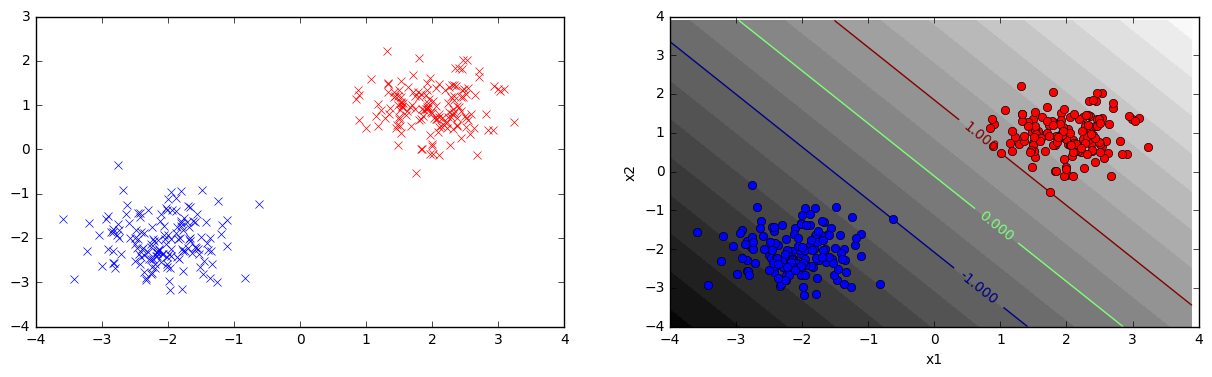

In [58]:
plt.figure(figsize=(15.0, 4.0))
#Plot the points
plt.subplot(1, 2, 1)
plot_dataset(X, y)

#Find an optimum thanks to cvxopt
start_time = time.time()
mu_support_cvxopt, idx_support_cvxopt = svm_solver(K, y) #We remove C
time_cvxopt = time.time() - start_time
print("SVM with cvxopt : %.3f seconds " % time_cvxopt)
print("Number of points : %s" %N, " ; sigma = %s" %s)
b_cvxopt = compute_b(K, y, mu_support_cvxopt, idx_support_cvxopt)

# Mu obtained with cvxopt
mu_cvxopt = np.zeros(N)
mu_cvxopt[idx_support_cvxopt] = mu_support_cvxopt

#Plot the classification
plt.subplot(1, 2, 2)
plot_classif(X, y, mu_support_cvxopt, idx_support_cvxopt, b_cvxopt)

In [59]:
#We check the gradient we computed
from scipy.optimize import check_grad

print(check_grad(f, grad_f, mu_cvxopt))

1.1575892963e-06


### Own version of proximal gradient without acceleration

According to the function $g$, the solution is a kind of projection on a hypercube $[0,C]^n$. That is why, we could use a proximal version, as we have done in TP2 : 

In [60]:
def ista(mu_init, f, grad_f, g, prox_g, step, n_iter, verbose=True) :
    """Proximal gradient descent algorithm"""
    mu = mu_init.copy()
    mu_new = mu_init.copy()
    n_samples, n_features = A.shape

    # objective history
    objectives = []
    
    # Current objective
    obj = f(mu) + g(mu)
    objectives.append(obj)
    
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]]))
        
    for k in range(n_iter + 1):

        mu = prox_g(mu - step * grad_f(mu))

        obj = f(mu) + g(mu)
        objectives.append(obj)
        
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8)])
            )
    return mu, objectives

In [61]:
start_time = time.time()
mu_ista, obj_ista = ista(mu_init, f, grad_f, g, prox_g, 1/lip(A), N_iter, verbose=False)
time_ista = time.time() - start_time
print("SVM with ISTA with %s iterations "%N_iter , ": %.3f seconds " % time_ista)

SVM with ISTA with 1000 iterations  : 0.577 seconds 


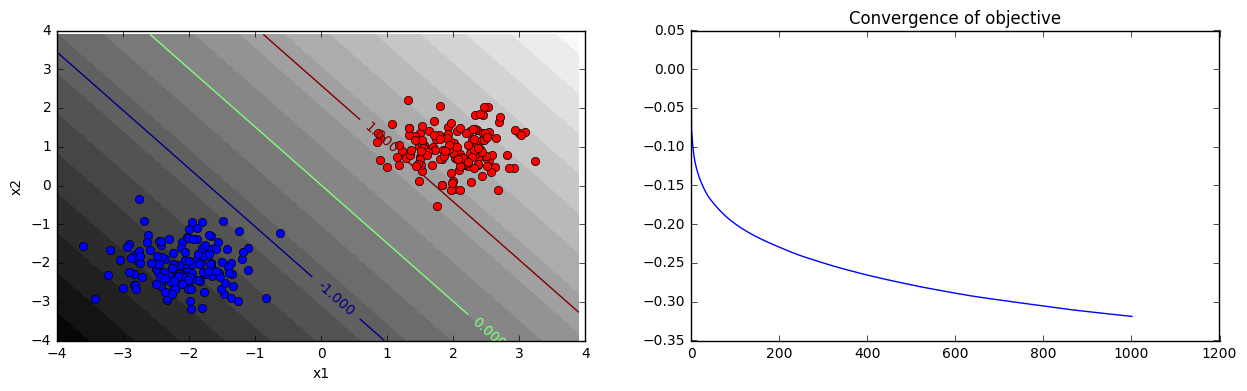

In [62]:
#Take the support vectors
idx_support_ista = np.where(np.abs(mu_ista) > 1e-5)[0]
mu_support_ista = mu_ista[idx_support_ista]

#Compute b
b_ista = compute_b(K, y, mu_support_ista, idx_support_ista)

#Plot
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 2, 1)
plot_classif(X, y, mu_support_ista, idx_support_ista, b_ista)
plt.subplot(1, 2, 2)
plt.title("Convergence of objective")
plt.plot(obj_ista)

### Own version of proximal gradient with acceleration

In [63]:
def fista(mu_init, f, grad_f, g, prox_g, step, n_iter, verbose=True):
    """Accelerated Proximal gradient descent algorithm"""
    
    mu = mu_init.copy()
    mu_new = mu_init.copy()
    
    # An extra variable is required for FISTA
    z = mu_init.copy()
    n_samples, n_features = A.shape
    
    # objective history
    objectives = []

    obj = f(mu) + g(mu)
    objectives.append(obj)
    
    t = 1.      #t1
    t_new = 1.  #t0

    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]]))
    for k in range(n_iter + 1):

        mu_new = mu.copy() #x0, x1
        mu = prox_g(z - step * grad_f(z)) #x1, x2

        t_new = t #t1, t2
        t = (1+np.sqrt(1+4*t_new**2))/2 #t2, t3
        z = mu + (t_new -1)/t * (mu-mu_new) #z2, z3

        obj = f(mu) + g(mu)
        objectives.append(obj)

        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8)])
                  )
    return np.array(mu), np.array(objectives)

In [64]:
start_time = time.time()
mu_fista, obj_fista = fista(mu_init, f, grad_f, g, prox_g, 1/lip(A), N_iter, verbose=False)
time_fista = time.time() - start_time
print("SVM with FISTA with %s iterations "%N_iter , ": %.3f seconds " % time_fista)

SVM with FISTA with 1000 iterations  : 0.597 seconds 


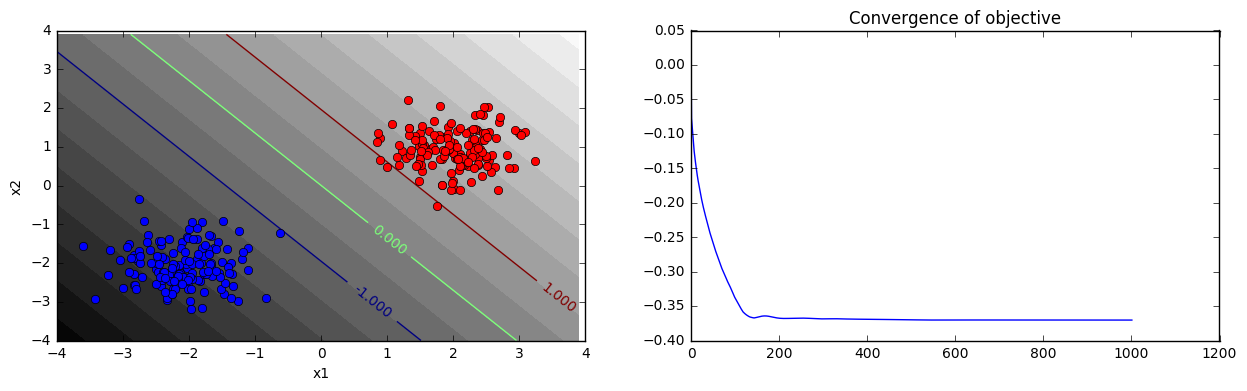

In [65]:
#Take the support vectors
idx_support_fista = np.where(np.abs(mu_fista) > 1e-5)[0]
mu_support_fista = mu_fista[idx_support_fista]

#Compute b
b_fista = compute_b(K, y, mu_support_fista, idx_support_fista)

#Plot
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 2, 1)
plot_classif(X, y, mu_support_fista, idx_support_fista, b_fista)
plt.subplot(1, 2, 2)
plt.title("Convergence of objective")
plt.plot(obj_fista)

As expected, we notice that the convergence is much faster with FISTA than with ISTA.

### Own version of coordinate descent with smart updates

For implement a version using smart updates on coordinate descent, one has to solve this problem : find $\delta^* \in \mathbb{R}^n$ such that : 
$$ \mu_i := \mu_i + \delta^*$$ leads to the solution.

For that, one can consider the gradient for $i$ and put it to 0.

We get : 
$$\begin{array}{rcl}
f(\mu+\delta e_i) - f(\mu) & = & \dfrac{1}{2}(\mu+\delta e_i)^{\top}GG^{\top}(\mu+\delta e_i) - (\mu+\delta e_i)^{\top}u - \dfrac{1}{2}\mu^{\top}GG^{\top}\mu + \mu^{\top}u\\
& = & \delta \mu^{\top} GG^{\top} e_i + \dfrac{\delta^2}{2} e_i^{\top} GG^{\top} e_i -\delta  \\
& =& \delta (GG^{\top} \mu)_i + \dfrac{\delta^2}{2} (GG^{\top})_{ii} -\delta
\end{array}$$

From then on, 
$$ \delta (GG^{\top} \mu)_i + \dfrac{\delta^2}{2} (GG^{\top})_{ii} -\delta = 0 \Longrightarrow \delta^* = \dfrac{1-(GG^{\top} \mu)_i}{(GG^{\top})_{ii}}$$

By the way, this method needs to compute $GG^{\top}$ which may no fit in memory ! Even if we can obtain $(GG^{\top})_{ii}$ without computing the whole $GG^{\top}$, one cannot do that with $(GG^{\top} \mu)_i$.  <br>
By $w =  \displaystyle \sum_{i=1}^{n} \mu_i y_i x_i$, we get $w = G^{\top}\mu$, so 
$$\begin{array}{rcl}
(GG^{\top} \mu)_i & = & (Gw)_i \\
& = & y_i x_i^{\top} w
\end{array}$$

To conclude, the update consists in reevalute $\delta^*$, $\mu_i$ and $w$ : 
$$ \delta^* = \dfrac{1-y_i x_i^{\top} w}{(GG^{\top})_{ii}}$$
$$ \mu_i := \mu_i + \delta^*$$
$$ w := w + \delta^*y_ix_i$$

Moreover, at each iteration, $\mu_i$ has to belong to $[0,C]$ : this constraint leads to $\forall i \in [\!1,n]\!]$ :
$$\begin{array}{rcl}
0 \leq \mu_i + \delta^* \leq C & <=> & - \mu_i \leq \delta^* \leq C - \mu_i \\
\end{array}$$

In [66]:
def cd(mu_init, G, g, prox_g, n_iter, verbose=True):
    """Coordinate descent algorithm"""
    
    mu = mu_init.copy()
    mu_new = mu_init.copy()
    n_samples = N

    #compute w from mu_init
    w = (mu_init * y).dot(X2)
    
    # objective history
    objectives = []
    
    # Current objective
    obj = f(mu) + g(mu)
    objectives.append(obj)

    if verbose:
        print("Lauching Coordinate Descent solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]]))

    #Compute all diagonal term of G * G^T
    diag_A = np.array([sum(G[i,:]**2) for i in range(N)])
        
    for k in range(n_iter + 1):

        #modulo
        i = k % n_samples
        
        #We have to respect some condition
        bound1 = C-mu[i]
        bound2 = -mu[i]
        
        #The 'naive' updates (without taking care of constraints on mu)
        num = 1- y[i]*X2[i,:].dot(w)
        denum = diag_A[i]
        fraction = num/denum
        
        #We filter the result to respect the constraints
        delta = np.maximum(np.minimum(bound1, fraction), bound2)
        
        #Update
        mu[i] += delta
        w += y[i] * delta * X2[i,:]
        
        obj = f(mu) + g(mu)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8)])
                 )
    return mu, objectives

SVM with 1000 iterations  : 0.082 seconds  


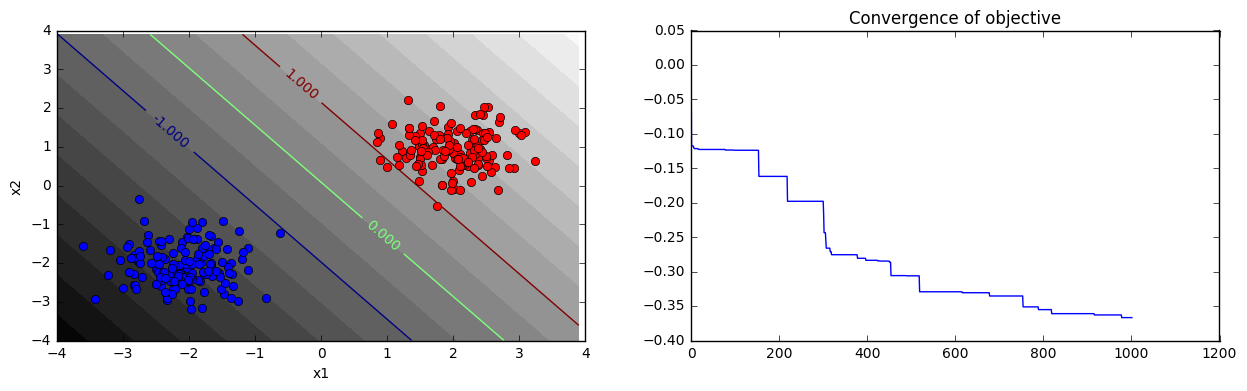

In [67]:
start_time = time.time()
mu_cd , obj_cd = cd(mu_init, G, g, prox_g, N_iter, verbose=False)
time_cd = time.time() - start_time
print("SVM with %s iterations "%N_iter , ": %.3f seconds  " % time_cd)

#Take the support vectors
idx_support_cd = np.where(np.abs(mu_cd) > 1e-5)[0]
mu_support_cd = mu_cd[idx_support_cd]

#Compute b
b_cd = compute_b(K, y, mu_support_cd, idx_support_cd)

#Plot
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 2, 1)
plot_classif(X, y, mu_support_cd, idx_support_cd, b_cd)
plt.subplot(1, 2, 2)
plt.title("Convergence of objective")
plt.plot(obj_cd)

### L-BFGS-B solver

SVM with L-BFGS-B with 1000 iterations  : 0.096 seconds 


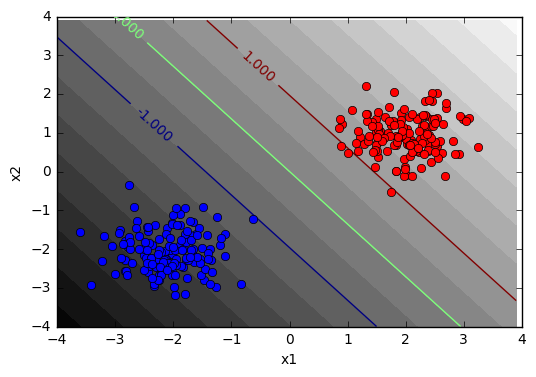

In [68]:
from scipy.optimize import fmin_l_bfgs_b

#Calculating the estimation of mu
start_time = time.time()
mu_bfgs, f_bfgs, d_bfgs = fmin_l_bfgs_b(f, mu_init, fprime = grad_f, bounds = [(0,C) for _ in range(N)], maxiter = N_iter)
time_bfgs = time.time() - start_time
print("SVM with L-BFGS-B with %s iterations "%N_iter , ": %.3f seconds " % time_bfgs)

#Take the support vectors
idx_support_bfgs = np.where(np.abs(mu_bfgs) > 1e-5)[0]
mu_support_bfgs = mu_bfgs[idx_support_bfgs]

#Compute b
b_bfgs = compute_b(K, y, mu_support_bfgs, idx_support_bfgs)

#Plot
plot_classif(X, y, mu_support_bfgs, idx_support_bfgs, b_bfgs)

### Comparison and benchmark

#### Quick comparison between ISTA, FISTA and Coordinate Descent

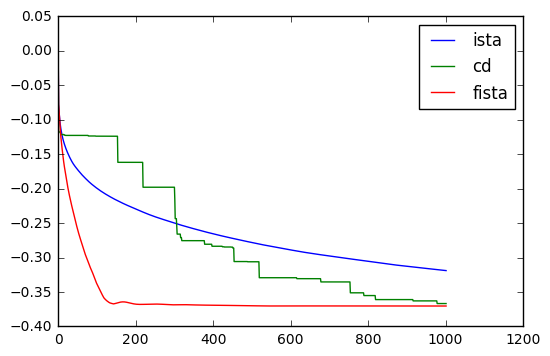

In [69]:
plt.plot(obj_ista)
plt.plot(obj_cd)
plt.plot(obj_fista)
plt.legend(['ista','cd','fista'])

The FISTA algorithm converges much faster than the ISTA and coordinate descent algorithms. 

#### Comparison of $\mu$ results

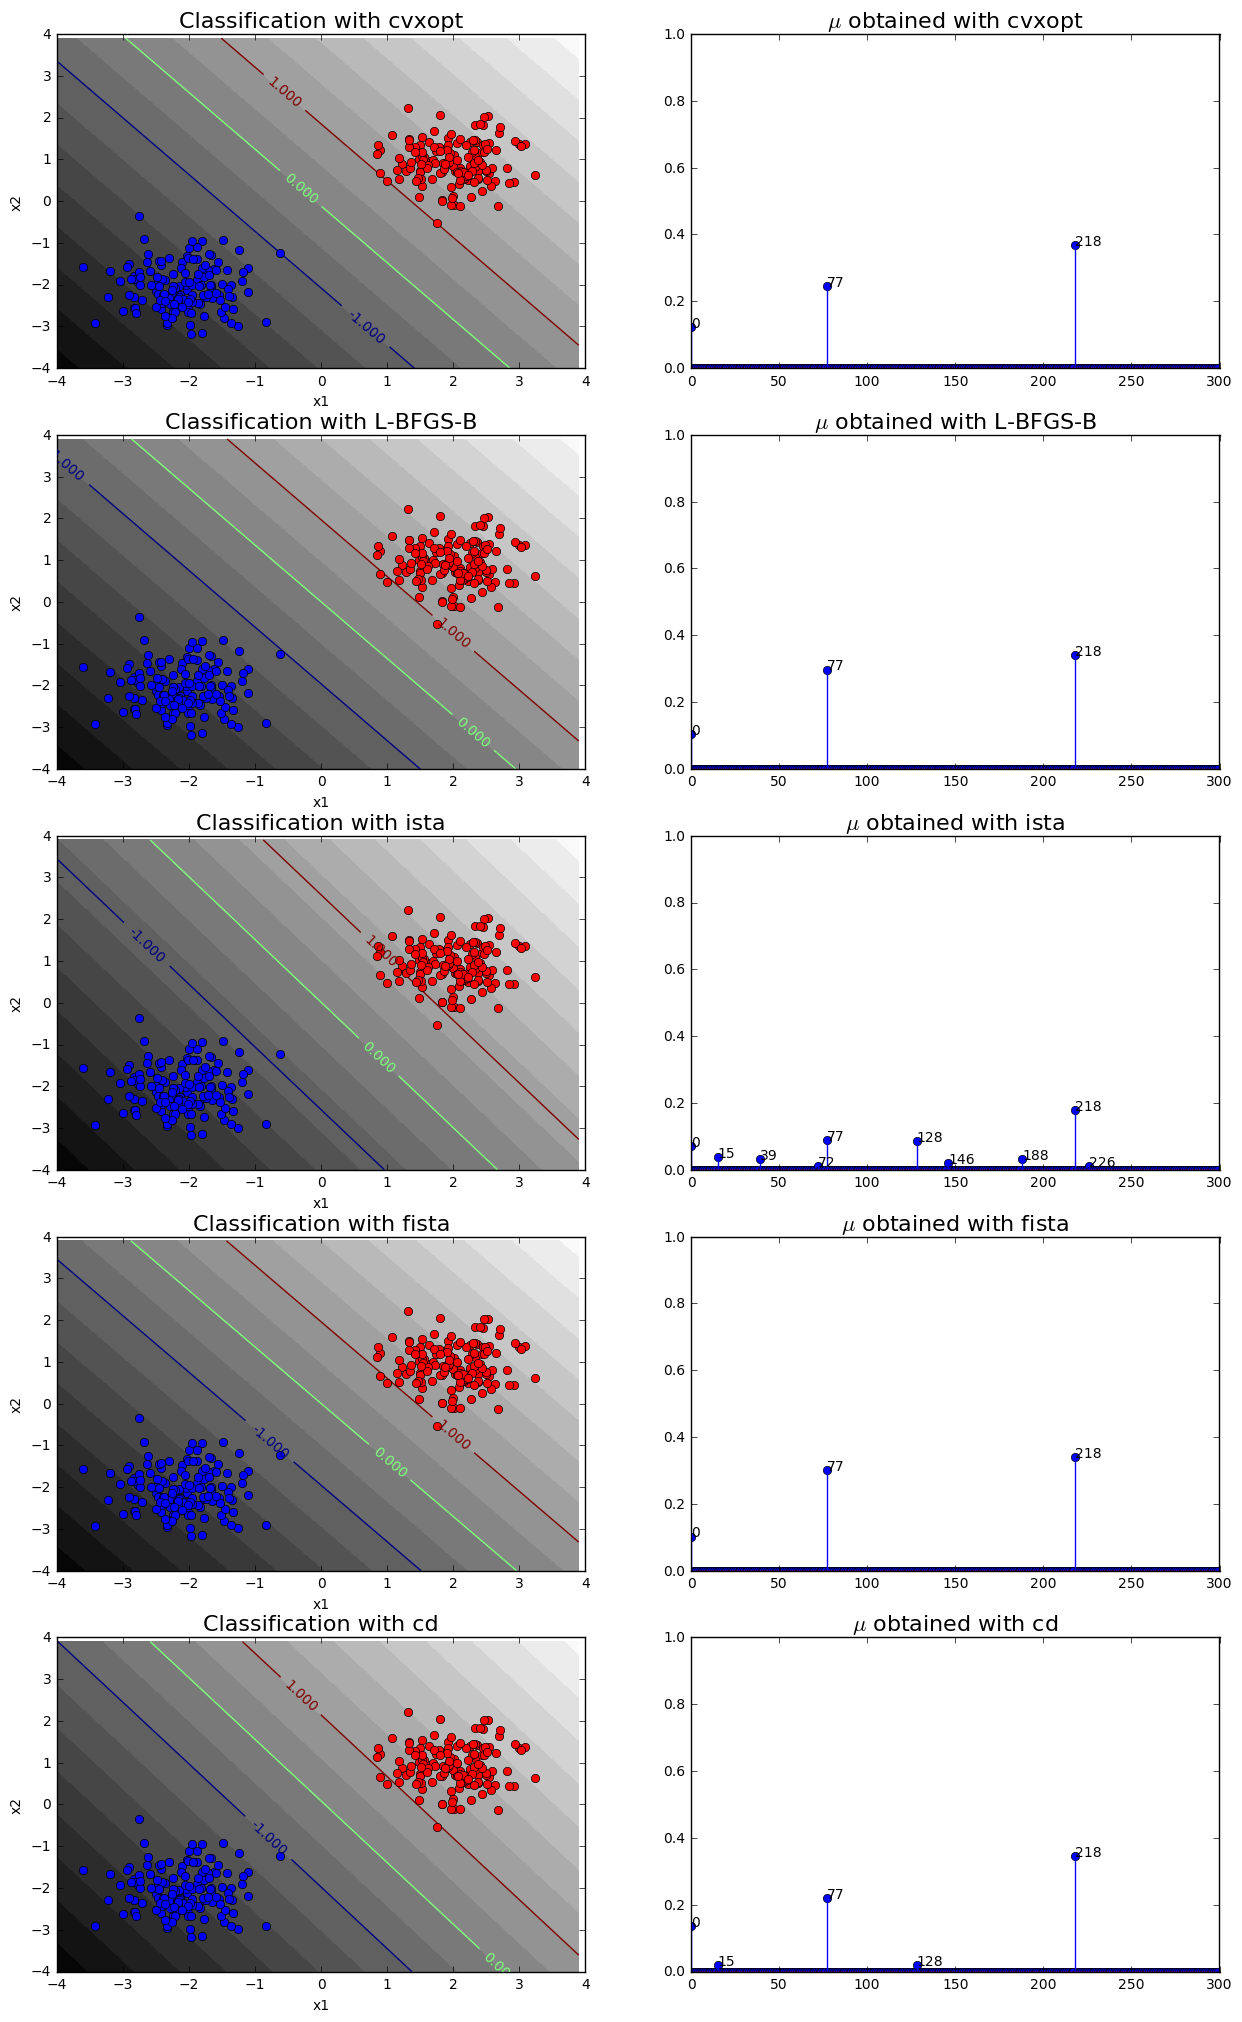

In [81]:
plt.figure(figsize=(15.0, 25.0))

plt.subplot(5,2,1)
plot_classif(X, y, mu_support_cvxopt, idx_support_cvxopt, b_cvxopt)
plt.title("Classification with cvxopt", fontsize=16)

plt.subplot(5, 2, 2)
plt.stem(mu_cvxopt)
for i, txt in enumerate(idx_support_cvxopt):
    plt.annotate(txt, (idx_support_cvxopt[i],mu_support_cvxopt[i]))
plt.title(r'$\mu$ obtained with cvxopt', fontsize=16)
plt.ylim([0, 1])

plt.subplot(5,2,3)
plot_classif(X, y, mu_support_bfgs, idx_support_bfgs, b_bfgs)
plt.title("Classification with L-BFGS-B", fontsize=16)

plt.subplot(5, 2, 4)
plt.stem(mu_bfgs)
for i, txt in enumerate(idx_support_bfgs):
    plt.annotate(txt, (idx_support_bfgs[i],mu_support_bfgs[i]))
plt.title(r'$\mu$ obtained with L-BFGS-B', fontsize=16)
plt.ylim([0, 1])

plt.subplot(5,2,5)
plot_classif(X, y, mu_support_ista, idx_support_ista, b_ista)
plt.title("Classification with ista", fontsize=16)

plt.subplot(5, 2, 6)
plt.stem(mu_ista)
for i, txt in enumerate(idx_support_ista):
    plt.annotate(txt, (idx_support_ista[i],mu_support_ista[i]))
plt.title(r'$\mu$ obtained with ista', fontsize=16)
plt.ylim([0, 1])

plt.subplot(5,2,7)
plot_classif(X, y, mu_support_fista, idx_support_fista, b_fista)
plt.title("Classification with fista", fontsize=16)

plt.subplot(5, 2, 8)
plt.stem(mu_fista)
for i, txt in enumerate(idx_support_fista):
    plt.annotate(txt, (idx_support_fista[i],mu_support_fista[i]))
plt.title(r'$\mu$ obtained with fista', fontsize=16)
plt.ylim([0, 1])

plt.subplot(5,2,9)
plot_classif(X, y, mu_support_cd, idx_support_cd, b_cd)
plt.title("Classification with cd", fontsize=16)

plt.subplot(5, 2, 10)
plt.stem(mu_cd)
for i, txt in enumerate(idx_support_cd):
    plt.annotate(txt, (idx_support_cd[i],mu_support_cd[i]))
plt.title(r'$\mu$ obtained with cd', fontsize=16)
plt.ylim([0, 1])

plt.show()

We notice that the $\mu$ obtained with cvxopt, L-BFGS-B and fista are almost the same, with three $\mu$ above 0 for 300 points. These three algorithms tend to give the same results for classification as well.

For coordinate descent, there are 5 $\mu$ above 0, for 300 points

For ista, there are 10 $\mu$ above 0, for 300 points. On the classification graph, the points appear more poorly classified than for the 4 other algorithms.



#### Comparison on performance of f and execution time

In [82]:
print(f(mu_cvxopt))
print(f(mu_ista))
print(f(mu_fista))
print(f(mu_cd))
print(f(mu_bfgs))

-0.368454935835
-0.318921001418
-0.370349979766
-0.366760590945
-0.370352834449


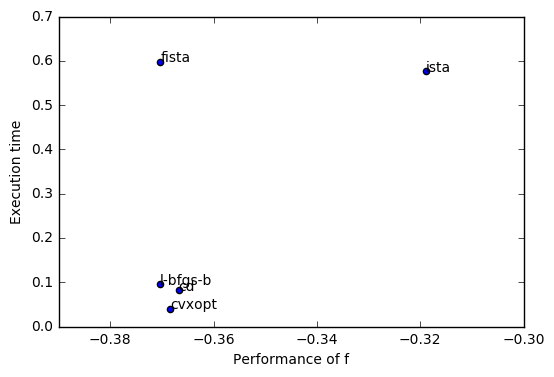

In [83]:
performance = np.array([f(mu_cvxopt), f(mu_ista), f(mu_fista), f(mu_cd), f(mu_bfgs)])
time_exec = np.array([time_cvxopt, time_ista, time_fista, time_cd, time_bfgs])

#name
name_model = np.array(["cvxopt", "ista", "fista", "cd", "l-bfgs-b"]) 
for i, txt in enumerate(name_model):
    plt.annotate(txt, (performance[i],time_exec[i]))

plt.xlabel("Performance of f")
plt.ylabel("Execution time")
plt.scatter(performance, time_exec)

We notice that the L-BFGS-B, coordinate descent and cvxpot algorithms have a similar performance as they all give a very close value (around -0.37 for f). They also have a very similar execution time, with cvxopt being twice as fast as the other two (0.05 second vs 0.1 second)

On the other hand, the ISTA algorithm is much slower (0.6 second to execute), and the performance over f is quite poor, compared to all the other algorithms. 

The FISTA algorithm is as slow as the ISTA algorithm, but it gives a good result for f (around -0.37 for f). 

For a number of points N=300, sigma s=0.5 and 1000 iterations, we would rank the algorithm in the following order for their time and convergence performances : 
1) CVXopt
2) L-BFGS-B 
3) Coordinate Descent
3) FISTA
5) ISTA

#### Effect of the number of points

We will check below if our coordinate descent can solve a problem with 10000 points (the matrix $GG^{\top}$ can no longer fit in memory).

In [87]:
#Choice of some parameters
C = 50 #coefficient C indicating our tolerance to misclassifying
N = 10000 #number of points
s = 0.5 #sigma

#Number of iterations
N_iter = 15000

#Initializatio for mu
mu_init = np.zeros(N)

In [88]:
#Get a dataset and transform it
X, y = datasets(name='gaussian', n_points = N, sigma = s)
X2 = np.concatenate((X, np.ones((len(X), 1))), axis=1)

#Compute some matrix
start_time = time.time()
G = compute_G(X2, y)
K = kernel(X2,X2) #takes a lot of time ...
time_mat = time.time() - start_time
print("Computation of the matrices : %.3f seconds " % time_mat)

SVM with CD : 30.590 seconds 


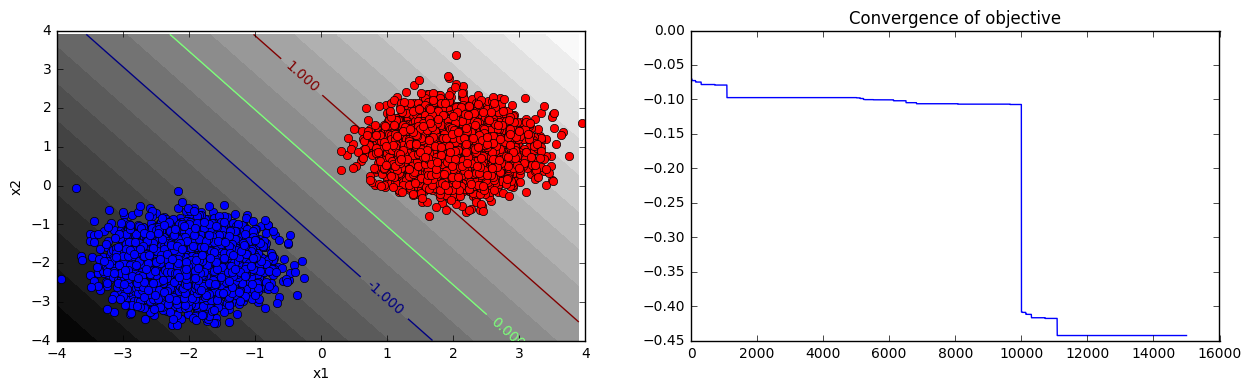

In [89]:
start_time = time.time()
mu_cd , obj_cd = cd(mu_init, G, g, prox_g, N_iter, verbose=False)
time_cd = time.time() - start_time
print("SVM with CD : %.3f seconds " % time_cd)

#Take the support vectors
idx_support_cd = np.where(np.abs(mu_cd) > 1e-5)[0]
mu_support_cd = mu_cd[idx_support_cd]

#Compute b
b_cd = compute_b(K, y, mu_support_cd, idx_support_cd)

#Plot
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 2, 1)
plot_classif(X, y, mu_support_cd, idx_support_cd, b_cd)
plt.subplot(1, 2, 2)
plt.title("Convergence of objective")
plt.plot(obj_cd)

We notice that the coordinate descent algorithm is able to solve a problem with 10 000 points, after a significant amount of time.